#  Many-Body Kernels for TDDFT Calculations  
**by <span style="color:darkgreen">Caterina Cocchi</span>, <span style="color:darkgreen">Santiago Rigamonti</span>, and <span style="color:darkgreen">Ronaldo Rodrigues Pela</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> and <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial we will learn how to perform a time-dependent density-functional (**TDDFT**) calculation using different **xc-kernels**. Three examples will be proposed: One for the **BSE**-derived **xc** kernel, one for the **LRC** kernel, and another for the **RBO** (**RPA-bootstrap**) kernel. As a test case, the optical spectrum of LiF will be studied.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Before Starting](#0)
    
[1. Calculation Setup](#1)
    
[2. Theoretical Background](#2)
    
[3. TDDFT Calculations Using the BSE-derived xc-kernel](#3)
    
[4. TDDFT Calculations Using the LRC and RBO Kernels](#4)
      
  - [Exercises](#5)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

**<span style="color:firebrick">Important note:</span>** All input parameters that will appear will be given in **atomic units**!

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Calculation Setup</span>

As a preliminary step for this excited-state calculation, a ground-state calculation will be performed. In this tutorial we consider as an example LiF. Create a directory named **run_LiF_TDDFT_kernels**. Inside the directory **run_LiF_TDDFT_kernels** we create a sub-directory **GS** where we perform the preliminary ground-state calculation:

In [1]:
%%bash
mkdir -p run_LiF_TDDFT_kernels && cd run_LiF_TDDFT_kernels
mkdir -p GS
cd ..

Inside the **GS** sub-directory we create the input file for LiF. In the <code><span style="color:green">structure</span></code> element we include the lattice parameter and basis vectors of LiF, which has a rock-salt cubic lattice, as well as the positions of the Li and F atoms. In the <code><span style="color:green">groundstate</span></code> element, we include a **10×10×10** k-point mesh (<code><span style="color:mediumblue">ngridk</span></code>) and a value of <code><span style="color:firebrick">14.0</span></code> for <code><span style="color:mediumblue">gmaxvr</span></code>. This value, which is larger than the default, is needed in view of the excited-state calculation (for details on this we refer to the tutorial **Excited States from BSE**).

The resulting input file is the following:

<span class="LiF_GS"></span>
```xml
<input>
 
   <title>LiF-BSE</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="7.608">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>
      <species speciesfile="F.xml">                                             
         <atom coord="0.5000  0.5000  0.5000" />                                
      </species>
      <species speciesfile="Li.xml">                                            
         <atom coord="0.0000  0.0000  0.0000" />                                
      </species>
   </structure>
 
   <groundstate
      ngridk="10  10  10"
      xctype="GGA_PBE_SOL"
      gmaxvr="14.0"/>
 
</input>

```

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("04_tutorial_many_body_kernels_for_tddft_calculations", "LiF_GS")

# Write out the input as an XML file:
with open('./run_LiF_TDDFT_kernels/GS/input.xml', "w") as fid:
    fid.write(input_str)

Do not forget to replace in the **input.xml** the actual value of the environment variable **$EXCITINGROOT**. You can do this by directly editing the **input.xml** file or by using the following command:

In [2]:
%%bash
cd run_LiF_TDDFT_kernels/GS
python3 -m excitingscripts.setup.excitingroot
cd ../..

Execute now the ground-state SCF calculation:

In [4]:
%%bash
cd run_LiF_TDDFT_kernels
python3 -m excitingscripts.execute.single -r GS
cd ..

If the run ends successfully, the files **STATE.OUT** and **EFERMI.OUT** will be present in the directory. These two files are needed as a starting point for the excited-state calculation.

<hr style="border:1px solid #DDD"> </hr>

<details>
<summary><strong><span style="color:firebrick">$\Rightarrow$ Additional details about the calculation workflow</span></strong>
 
<hr style="border:1px solid #DDD"> </hr>    
    
</summary>  

The work-flow of the algorithm is a combination of the **TDDFT** linear response calculation (see tutorial **Excited states from TDDFT**) and the calculation of the direct term of the **BSE** Hamiltonian, which is then used to set up a **MBPT**-derived kernel in first order. This kernel then enters the Dyson equation for the response function in the last stage of the **TDDFT** formalism.



<figure>
<img src=" 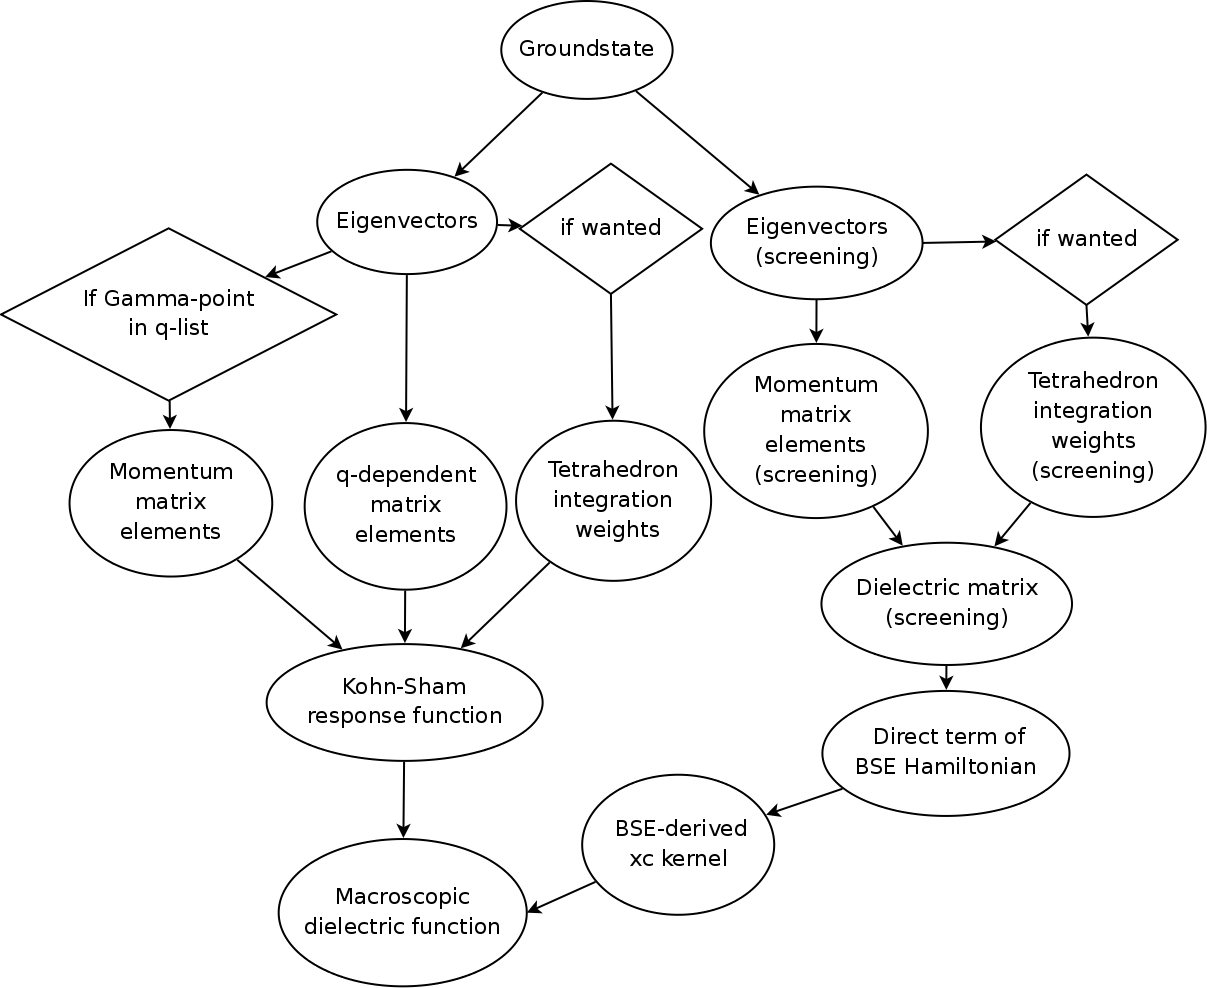" width="600" align="left"/>
</figure>
</details>

<a id='1'></a>
### <span style="color:#15317E">2. Theoretical Background</span>

There is a large literature dealing with the inclusion of many-body effects into **TDDFT** kernels, in order to correctly reproduce excitonic features (for further details we refer the seminal review provided in **[<span style="color:firebrick">Ref.[1]</span>](#5)**. In the following, we will present examples related to two different approaches. In the first one we will present a **TDDFT** calculation of the optical spectrum of LiF performed with a **xc** kernel derived from the solution of the Bethe-Sapeter equation (**BSE**). In the second part of the tutorial, we will deal with kernels including the so-called **long-range correction** (**LRC**).

In the example treating the **BSE**-derived **xc** kernel, the scheme proposed in **[<span style="color:firebrick">Ref.[2]</span>](#5)** is adopted. In this approach, a nonlocal exchange-correlation functional is derived by imposing **TDDFT** to reproduce the many-body diagrammatic expansion of the Bethe-Salpeter polarization function. In this way, it is shown that the **TDDFT** kernel is able to capture the excitonic features in solids, otherwise missing in simpler approximation for the kernel. For further details about the implementation in the code, see **[<span style="color:firebrick">Ref.[3]</span>](#5)**.

**LRC** kernels include the long-range component, which is missing at the level of the adiabatic local-density approximation (**ALDA**). The first model for a **LRC** kernel was proposed in **[<span style="color:firebrick">Ref.[4]</span>](#5)**:

\begin{equation}
\tag{1}
 f_{\rm xc}(\mathbf{q},\omega) = - \frac{\alpha}{\mathbf{q}^2}\;.
\end{equation}

This kernel is **static**, **non-local**, and includes the long-range Coulomb tail. In this model, $\alpha$ is a material dependent parameter. An improvement of this kernel is given in **[<span style="color:firebrick">Ref.[5]</span>](#5)**, where a **dynamical LRC** kernel was developed, which explicitly presents a frequency dependence:

\begin{equation}
\tag{2}
f_{\rm xc}(\mathbf{q},\omega)=-\frac{1}{\mathbf{q}^2}\left(\alpha+\beta\, \omega^2\right)\;.
\end{equation}

The values of $\alpha$ and $\beta$ are also material dependent and have to be tuned in order to correctly reproduce the experimental data for the excitons. For further details about the model we refer to the original paper **[<span style="color:firebrick">[5]</span>](#5)**.

The **RBO** kernel (see **[<span style="color:firebrick">[6]</span>](#5)** and **[<span style="color:firebrick">[7]</span>](#5)**) shares similar characteristics to the **LRC** kernel: It is long-ranged and static. An important difference is, however, that it does not depend on adjustable parameters, like the parameter $\alpha$, but is fully ab-initio. It is explicitly given by (**[<span style="color:firebrick">[7]</span>](#5)**)

\begin{equation}
\tag{3}
f_{\textrm{xc},\hspace{0.3mm}\textrm{RBO}}\hspace{-0.4mm}(\mathbf{q}) = \frac{1}{\varepsilon^\phantom{I}_{\textrm{M},\hspace{0.3mm}\textrm{RPA}}\hspace{-0.4mm}(\mathbf{q},\omega=0)\:\overline{\chi}^{\phantom{I}_\phantom{I}}_{\textrm{RPA}}\hspace{-0.4mm}(\mathbf{q},\omega=0)}\;,
\end{equation}

where $\varepsilon^{\phantom{I}}_{\textrm{M},\hspace{0.3mm}\textrm{RPA}}$ and $\overline{\chi}^{\phantom{I}_\phantom{I}}_{\textrm{RPA}}$ are, respectively, the macroscopic dielectric function and the modified density-response function (**[<span style="color:firebrick">Ref.[1]</span>](#5)**) in the random-phase approximation (**RPA**).

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. TDDFT Calculations Using the BSE-derived xc-kernel</span>

We are now ready to set up the **TDDFT** calculation of LiF, using a **BSE**-derived **xc** kernel. First of all, we move back to the parent directory. There, we create a new directory called **BSE_kernel** and move into it. We copy into it the files **STATE.OUT** and **EFERMI.OUT**, as well as the input file from the **GS** folder.

In [5]:
%%bash
cd run_LiF_TDDFT_kernels
mkdir -p BSE_kernel && cd BSE_kernel
cp ../GS/{input.xml,EFERMI.OUT,STATE.OUT} ./
cd ../..

Then, in the file **input.xml** the ground-state calculation can be skipped. To do so, set the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>. Then, paste the following <code><span style="color:green">xs</span></code> block:

```xml
...
   <xs 
      xstype="TDDFT" 
      ngridk="4 4 4" 
      vkloff="0.097 0.273 0.493"
      ngridq="4 4 4"
      nempty="3"
      gqmax="3.0"
      broad="0.007"
      scissor="0.2095"
      tevout="true">
 
      <energywindow 
         intv="0.0 1.0" 
         points="1200"/>
 
      <screening 
         screentype="full"
         nempty="100"/>
 
      <tddft
         fxctype="MB1"
         aresdf="false"
         aresfxc="false"/>
 
      <BSE 
         bsetype="singlet"
         nstlbse="1 5 1 4"
         />
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>
 
   </xs>       
...
```

In [6]:
# The following lines modify the input.xml using Python
from excitingtools import ExcitingInputXML, ExcitingXSInput

parsed_input = ExcitingInputXML.from_xml('./run_LiF_TDDFT_kernels/BSE_kernel/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [4, 4, 4],
      'vkloff': [0.097, 0.273, 0.493],
      'ngridq': [4, 4, 4],
      'nempty': 3,
      'gqmax': 3.0,
      'broad': 0.007,
      'scissor': 0.2095,
      'tevout': True,
      'energywindow': {'intv': [0.0, 1.0], 'points': 1200},
      'screening': {'screentype': 'full', 'nempty': 100},
      'tddft': {'fxctype': 'MB1', 'aresdf': False, 'aresfxc': False},
      'BSE': {'bsetype': 'singlet', 'nstlbse': [1, 5, 1, 4]},
      'qpointset': [[0.0, 0.0, 0.0]]}

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_LiF_TDDFT_kernels/BSE_kernel/input.xml')

This block is very similar to the one presented in the tutorial **Excited States from BSE**, to which we refer for an exhaustive description of the input attributes. In the following, we discuss only the relevant parameters for the **TDDFT** calculation with a **BSE**-derived kernel.

1. In the <code><span style="color:green">xs</span></code> element we set the attribute <code><span style="color:mediumblue">xstype</span>=<span style="color:firebrick">"TDDFT"</span></code>, as we are performing a **TDDFT** calculation;
2. We decrease the number of empty states with respect to the example in **Excited States from BSE** by choosing (<code><span style="color:mediumblue">nempty</span>=<span style="color:firebrick">"3"</span></code>) to speed up the calculation;
3. Both <code><span style="color:green">tddft</span></code> and <code><span style="color:green">bse</span></code> elements appear in the input file;
4. Inside the <code><span style="color:green">tddft</span></code> element, we specify the parameters related to **TDDFT** calculations. We refer to **Excited States from TDDFT** for additional details about this element. In this case we choose a many-body, **BSE**-derived kernel <code><span style="color:mediumblue">fxctype</span>=<span style="color:firebrick">"MB1"</span></code> and we set to <code><span style="color:firebrick">"false"</span></code> the attributes <code><span style="color:mediumblue">aresdf</span></code> and <code><span style="color:mediumblue">aresfxc</span></code> to speed up the calculation (for further details see the **[<span style="color:firebrick">Input Reference</span>](https://www.exciting-code.org/home/about/input-reference)**);
5. The <code><span style="color:green">bse</span></code> element must be specified to generate the kernel.

To run the calculation, type:

In [7]:
%%bash
cd run_LiF_TDDFT_kernels
python3 -m excitingscripts.execute.single -r BSE_kernel
cd ..

Once the run is completed, we can analyze the results. As in any **TDDFT** calculation, a number of output files are created (see also **Excited States from TDDFT** for additional details). Here we are interested in the files named **EPSILON_NAR_FXCMB1_OCYY_QMT001.OUT** (**YY** = **11**, **22**, and **33**) and specifically in the imaginary part of the macroscopic dielectric function, giving the optical absorption spectrum.

In order to visualize, e.g., the "**11**" component of the spectrum (notice that, as LiF has a cubic crystal structure, the three diagonal components are the same!), type:

In [10]:
%%bash
cd run_LiF_TDDFT_kernels/BSE_kernel
python3 -m excitingscripts.plot.spectra -f EPSILON_NAR_FXCMB1_OC11_QMT001.OUT -pn 'MB1'
cd ../..

This will generate a file named **MB1.png** as output. The resulting plot is the following:

<figure>
<img src=" 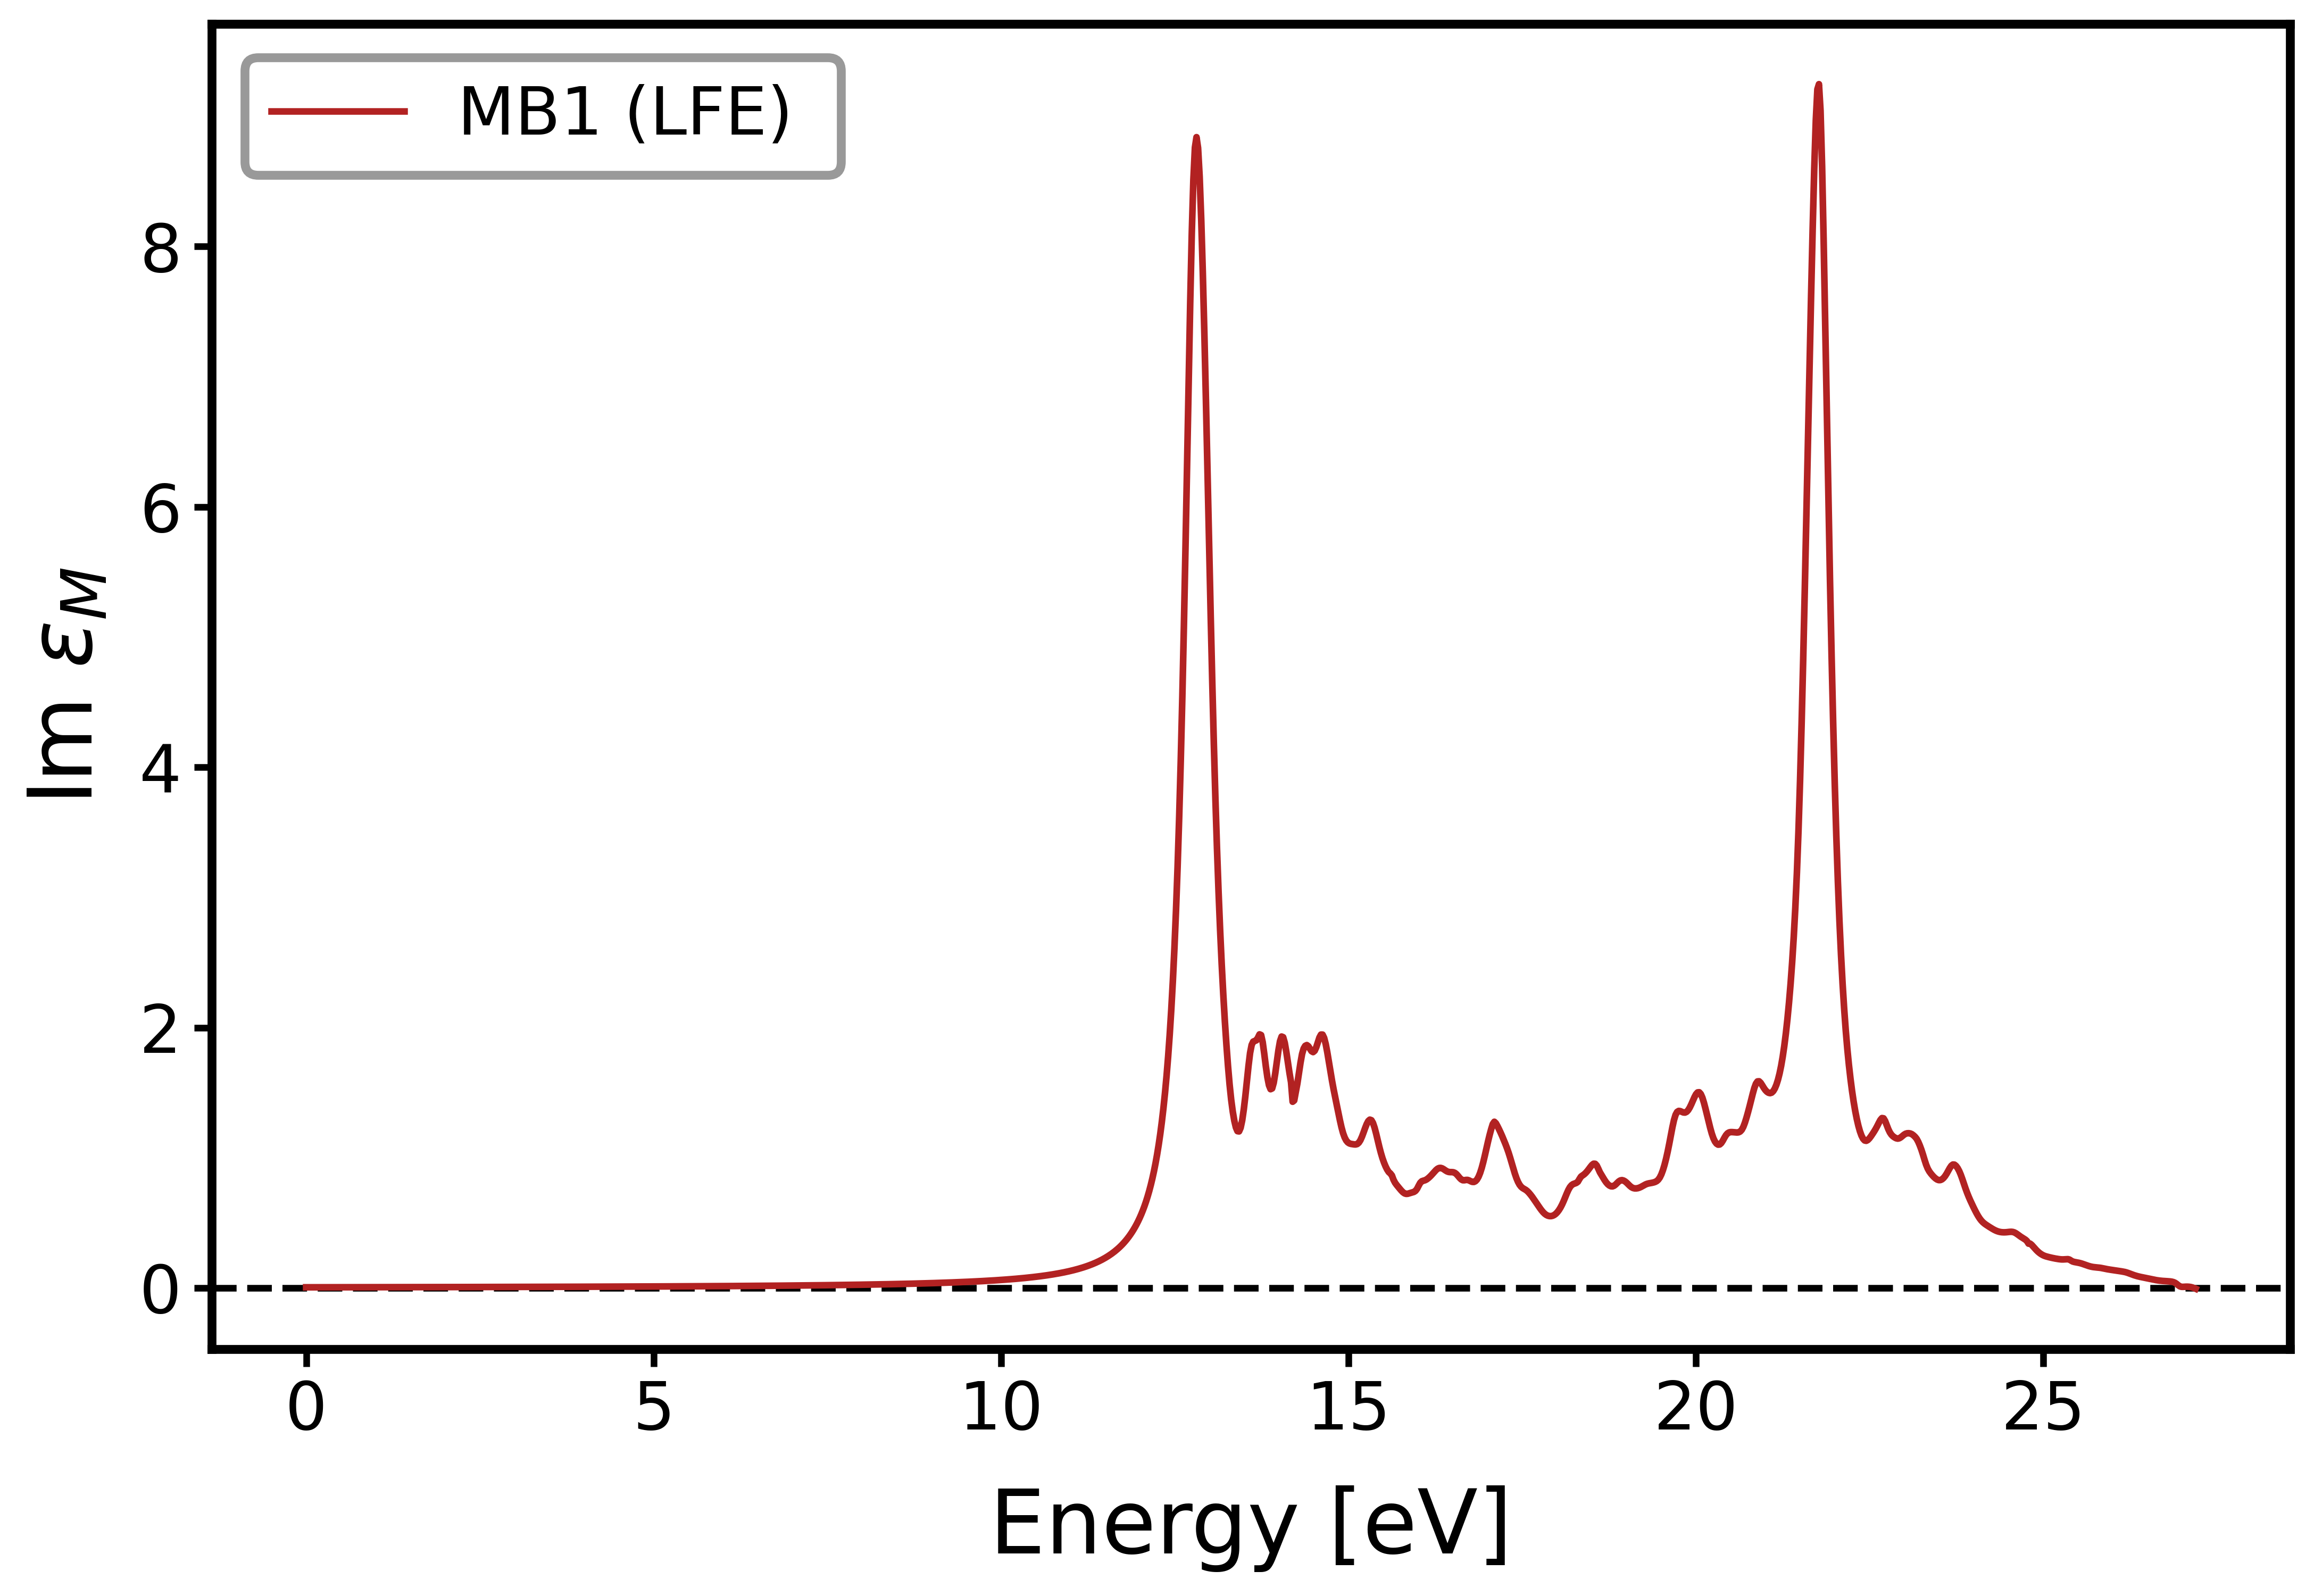" width="500" align="left"/>
</figure>

The main features of the optical spectrum are clearly visible in the graph. The intense excitonic peak at about 13 eV dominates the low energy part of the spectrum and another strong peak is found above 20 eV. This result is in agreement with the spectrum obtained by solving the **BSE** equation (see **Excited States from BSE**). For a comparison with the literature, see **[<span style="color:firebrick">Ref.[2]</span>](#5)**.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. TDDFT Calculations Using the LRC and RBO Kernels</span>

As usual, we recommend to move to the parent directory and create a new folder where running the **TDDFT** calculation with the **LRC** and **RBO** kernels. We copy into it the files **STATE.OUT** and **EFERMI.OUT**, as well as the input file from the **GS** folder.

In [11]:
%%bash
cd run_LiF_TDDFT_kernels
mkdir -p LRC_RBO_kernel && cd LRC_RBO_kernel
cp ../GS/{input.xml,EFERMI.OUT,STATE.OUT} ./
cd ../..

Then, in the file **input.xml** the ground-state calculation can be skipped by setting the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>. Then, paste the following <code><span style="color:green">xs</span></code> block:

```xml
...
   <xs 
      xstype="TDDFT" 
      ngridk="4 4 4" 
      vkloff="0.097 0.273 0.493"
      nempty="5"
      gqmax="3.0"
      broad="0.007"
      scissor="0.2095"
      tevout="true">
 
      <energywindow 
         intv="0.0 1.0" 
         points="1200"/>
 
      <tddft
         fxctype="LRCstatic"
         alphalrc="10.0"/>
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>
 
   </xs>           
...
```

In [12]:
parsed_input = ExcitingInputXML.from_xml('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [4, 4, 4],
      'vkloff': [0.097, 0.273, 0.493],
      'nempty': 5,
      'gqmax': 3.0,
      'broad': 0.007,
      'scissor': 0.2095,
      'tevout': True,
      'energywindow': {'intv': [0.0, 1.0], 'points': 1200},
      'tddft': {'fxctype': 'LRCstatic', 'alphalrc': 10.0},
      'qpointset': [[0.0, 0.0, 0.0]]}

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

With respect to the previous example on **BSE**-derived kernel first of all we notice that the <code><span style="color:green">bse</span></code> element has disappeared: This is actually a purely **TDDFT** calculation. Inside the <code><span style="color:green">tddft</span></code> element we have changed the attribute <code><span style="color:mediumblue">fxctype</span></code> to <code><span style="color:firebrick">"LRCstatic"</span></code>: In this way we are setting the exchange-correlation kernel to be the **LRC static** one **[<span style="color:firebrick">[4]</span>](#5)**. The crucial parameter in this calculation is <code><span style="color:mediumblue">alphalrc</span></code>, which determines the value of $\alpha$ in the expression of the kernel $f_{xc}(\mathbf{q},\omega) = - \alpha/\mathbf{q}^2$. This is a dimensionless number, which we choose here to be equal to **10.0**. Run the calculation (note that it will take much shorter than the calculation with the **BSE**-derived kernel!).

In [13]:
%%bash
cd run_LiF_TDDFT_kernels
python3 -m excitingscripts.execute.single -r LRC_RBO_kernel
cd ..

To plot the resulting optical absorption spectrum run

In [14]:
%%bash
cd run_LiF_TDDFT_kernels/LRC_RBO_kernel
python3 -m excitingscripts.plot.spectra -f EPSILON_FXCLRCstatic_OC11_QMT001.OUT -pn 'LRCstatic'
cd ../..

The result should look like this:

<figure>
<img src=" 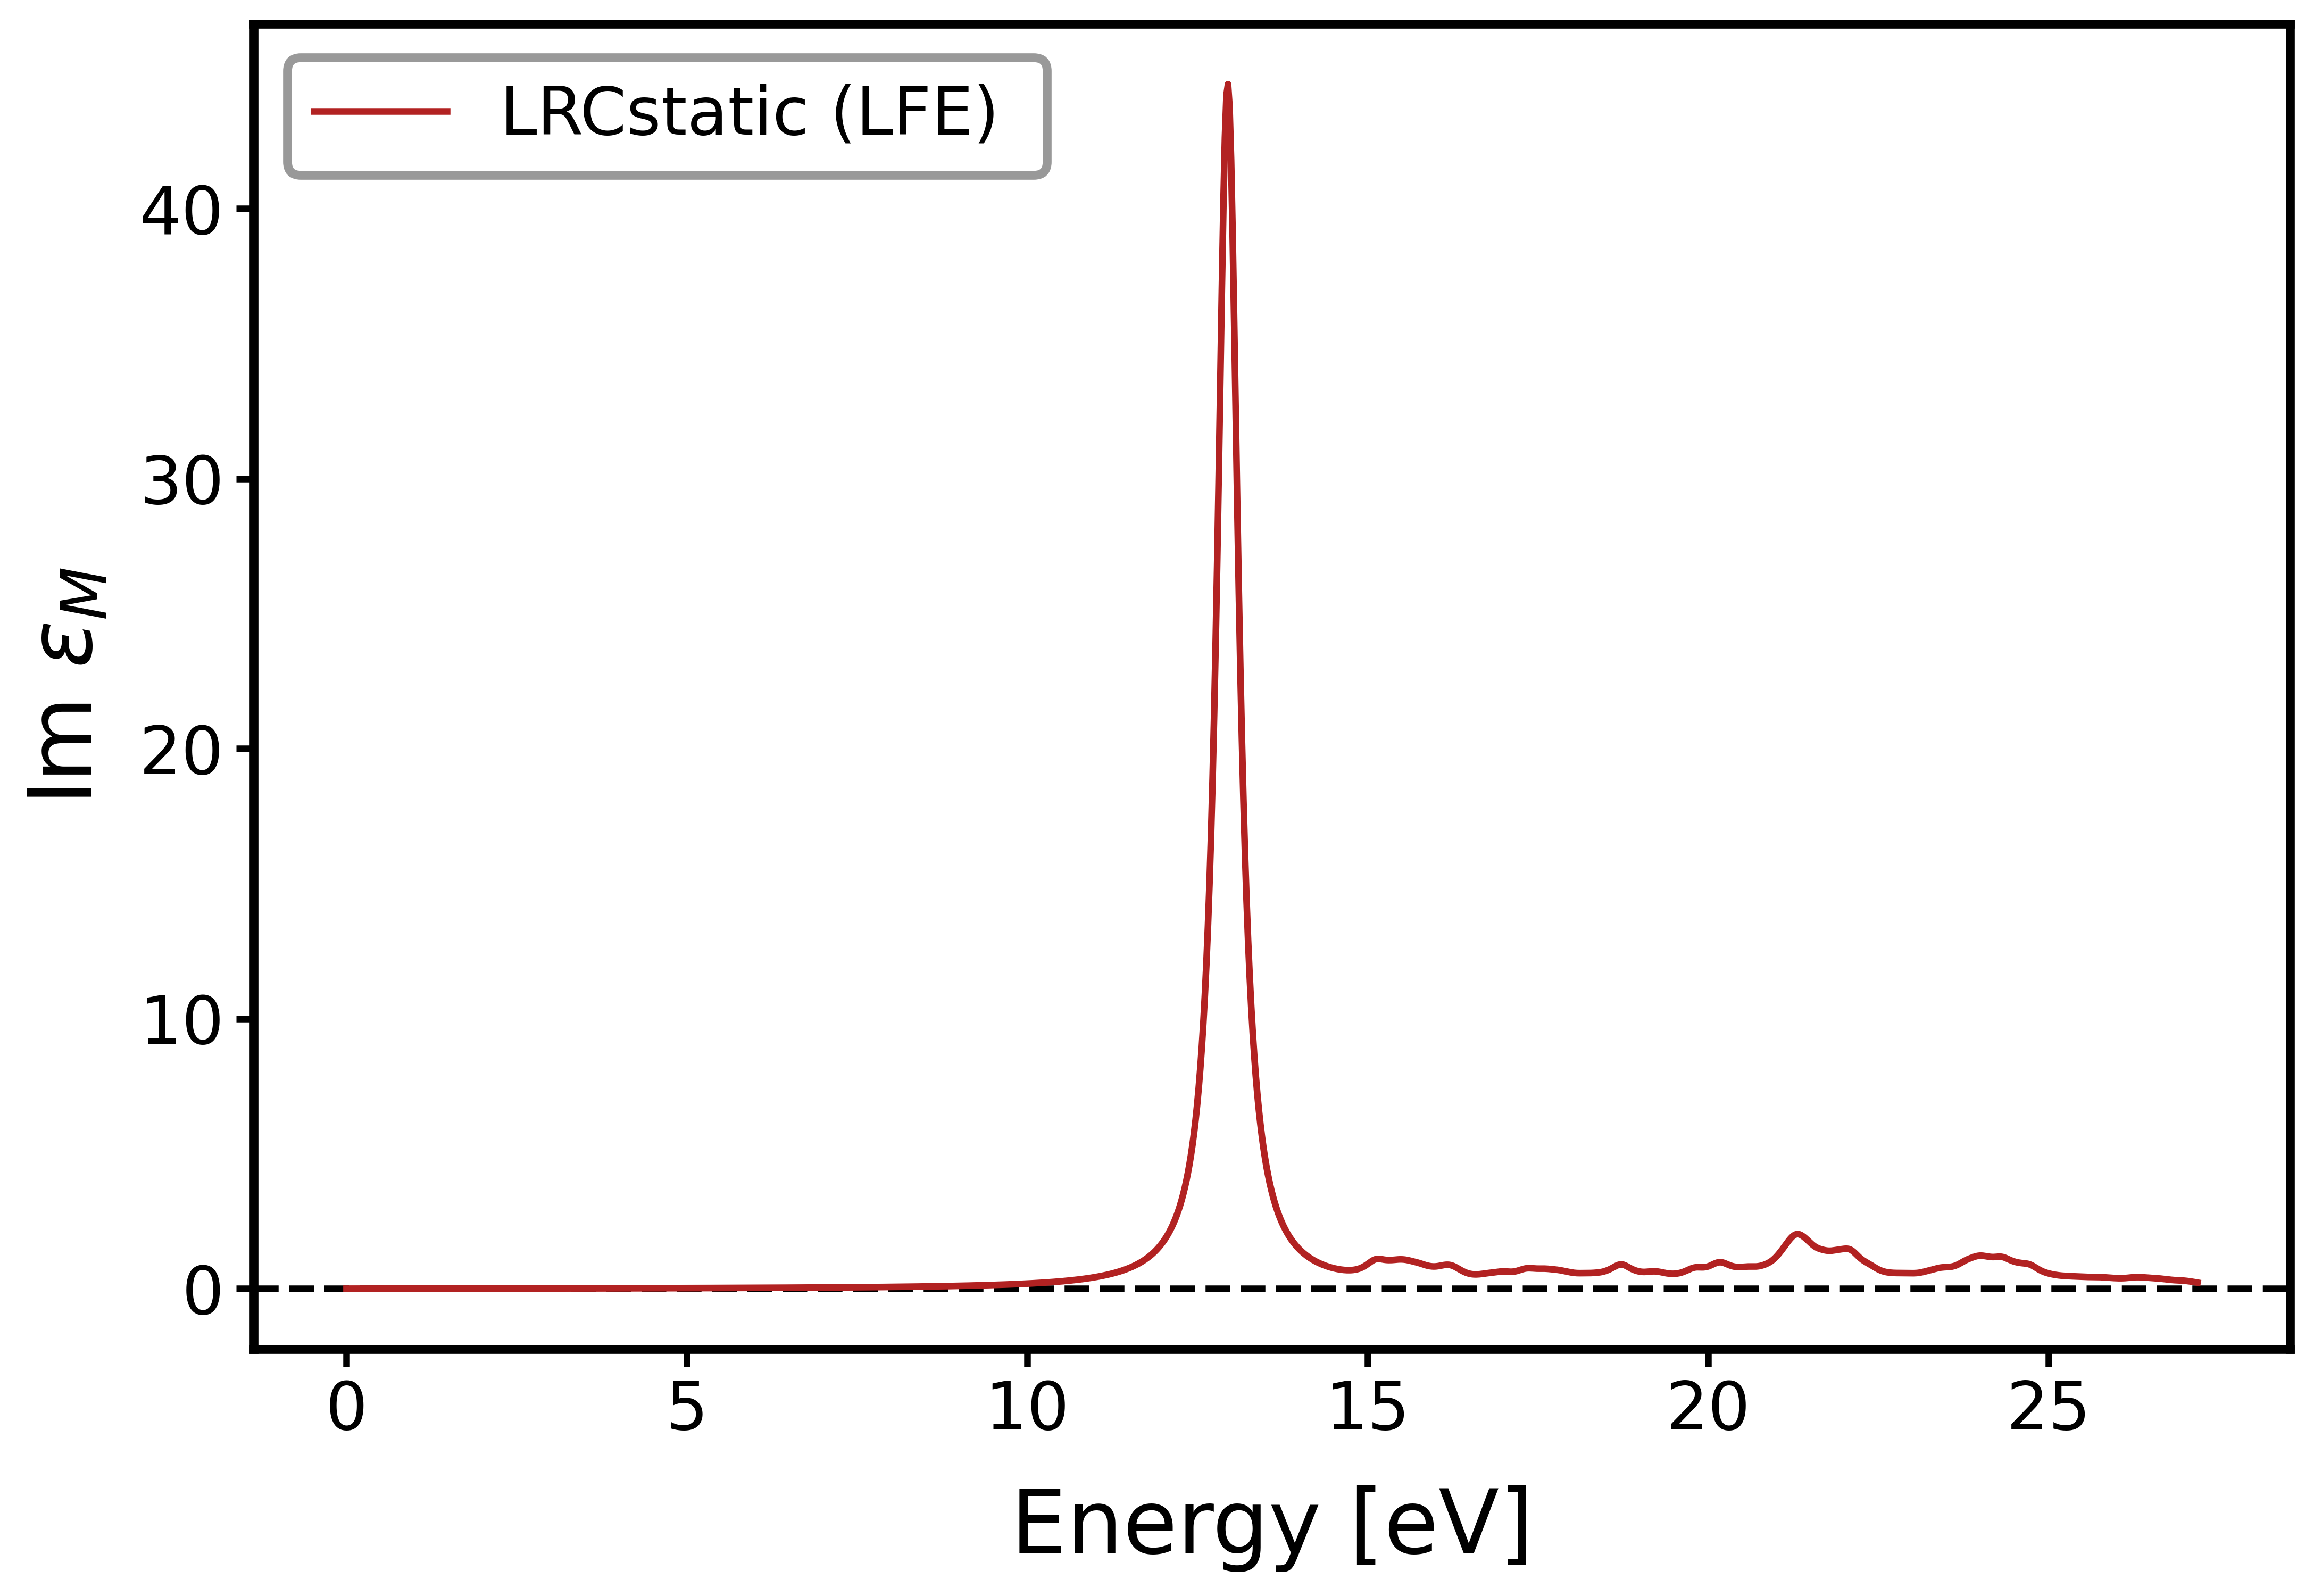" width="500" align="left"/>
</figure>

In the plot above, the strong excitonic peak at about 12.5 eV characterizing the spectrum of LiF is correctly reproduced by the **TDDFT** calculation with the **static LRC** kernel. Compared to the result obtained with the **BSE**-derived kernel the main differences appear in the higher energy region of the spectrum, above 20 eV. However, the purpose to correctly reproduce the intense bound exciton of LiF is fulfilled.

Next, we now compare this result with that obtained with the **dynamical LRC kernel**. In this case, the <code><span style="color:green">xs</span></code> block in the input file is the following:

```xml
...
   <xs 
      xstype="TDDFT" 
      ngridk="4 4 4" 
      vkloff="0.097 0.273 0.493"
      nempty="5"
      gqmax="3.0"
      broad="0.007"
      scissor="0.2095"
      tevout="true">
 
      <energywindow 
         intv="0.0 1.0" 
         points="1200"/>
 
      <tddft
         fxctype="LRCdyn"
         alphalrcdyn="2.0"
         betalrcdyn="35.6"/>
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>
 
   </xs>    
...
```

In [15]:
parsed_input = ExcitingInputXML.from_xml('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [4, 4, 4],
      'vkloff': [0.097, 0.273, 0.493],
      'nempty': 5,
      'gqmax': 3.0,
      'broad': 0.007,
      'scissor': 0.2095,
      'tevout': True,
      'energywindow': {'intv': [0.0, 1.0], 'points': 1200},
      'tddft': {'fxctype': 'LRCdyn', 'alphalrcdyn': 2.0, 'betalrcdyn': 35.6},
      'qpointset': [[0.0, 0.0, 0.0]]}

parsed_input.xs = ExcitingXSInput(**xs)

parsed_input.write('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

Only the <code><span style="color:green">tddft</span></code> element is modified compared to the **static** case. The attribute <code><span style="color:mediumblue">fxctype</span></code> is set to <code><span style="color:firebrick">"LRCdyn"</span></code> to choose the **dynamical** $f_{xc}$ quoted in **[<span style="color:firebrick">Ref.[5]</span>](#5)**. In this case, two parameters must be tuned, namely <code><span style="color:mediumblue">alphalrcdyn</span></code> and <code><span style="color:mediumblue">betalrcdyn</span></code>, which correspond respectively to $\alpha$ (**dimensionless**) and $\beta$ (**Ha<sup>-2</sup>**) in the model kernel of **Eq. (2)**. The parameters appearing in **Eqs. (1)** and **(2)** are chosen such that the calculated **BSE** energy peak coincides with the experimental one. For more details we refer to the original paper **[<span style="color:firebrick">[5]</span>](#5)**. As a rule of a thumb, the parameters <code><span style="color:mediumblue">alphalrcdyn</span></code> and <code><span style="color:mediumblue">betalrcdyn</span></code> can be set in order to mimic the behavior of <code><span style="color:mediumblue">alphalrc</span></code> in the **static LRC** kernel:

\begin{equation}
\tag{4}
\alpha_{\rm dyn} + \beta\; \omega_{\rm peak}^2 = \alpha_{\rm static}\;,
\end{equation}

where $\omega_{\rm peak}$ indicates the position of the first excitonic peak for LiF at 12.9 eV. Choosing a value of **2.0** for <code><span style="color:mediumblue">alphalrcdyn</span></code>, as suggested in **[<span style="color:firebrick">Ref.[5]</span>](#5)** one obtains **35.6** for <code><span style="color:mediumblue">betalrcdyn</span></code>.

In [16]:
%%bash
cd run_LiF_TDDFT_kernels
python3 -m excitingscripts.execute.single -r LRC_RBO_kernel
cd ..

To plot the spectrum run

In [17]:
%%bash
cd run_LiF_TDDFT_kernels/LRC_RBO_kernel
python3 -m excitingscripts.plot.spectra -f EPSILON_FXCLRCdyn_OC11_QMT001.OUT -pn 'LRCdyn'
cd ../..

The resulting optical spectrum is:

<figure>
<img src=" 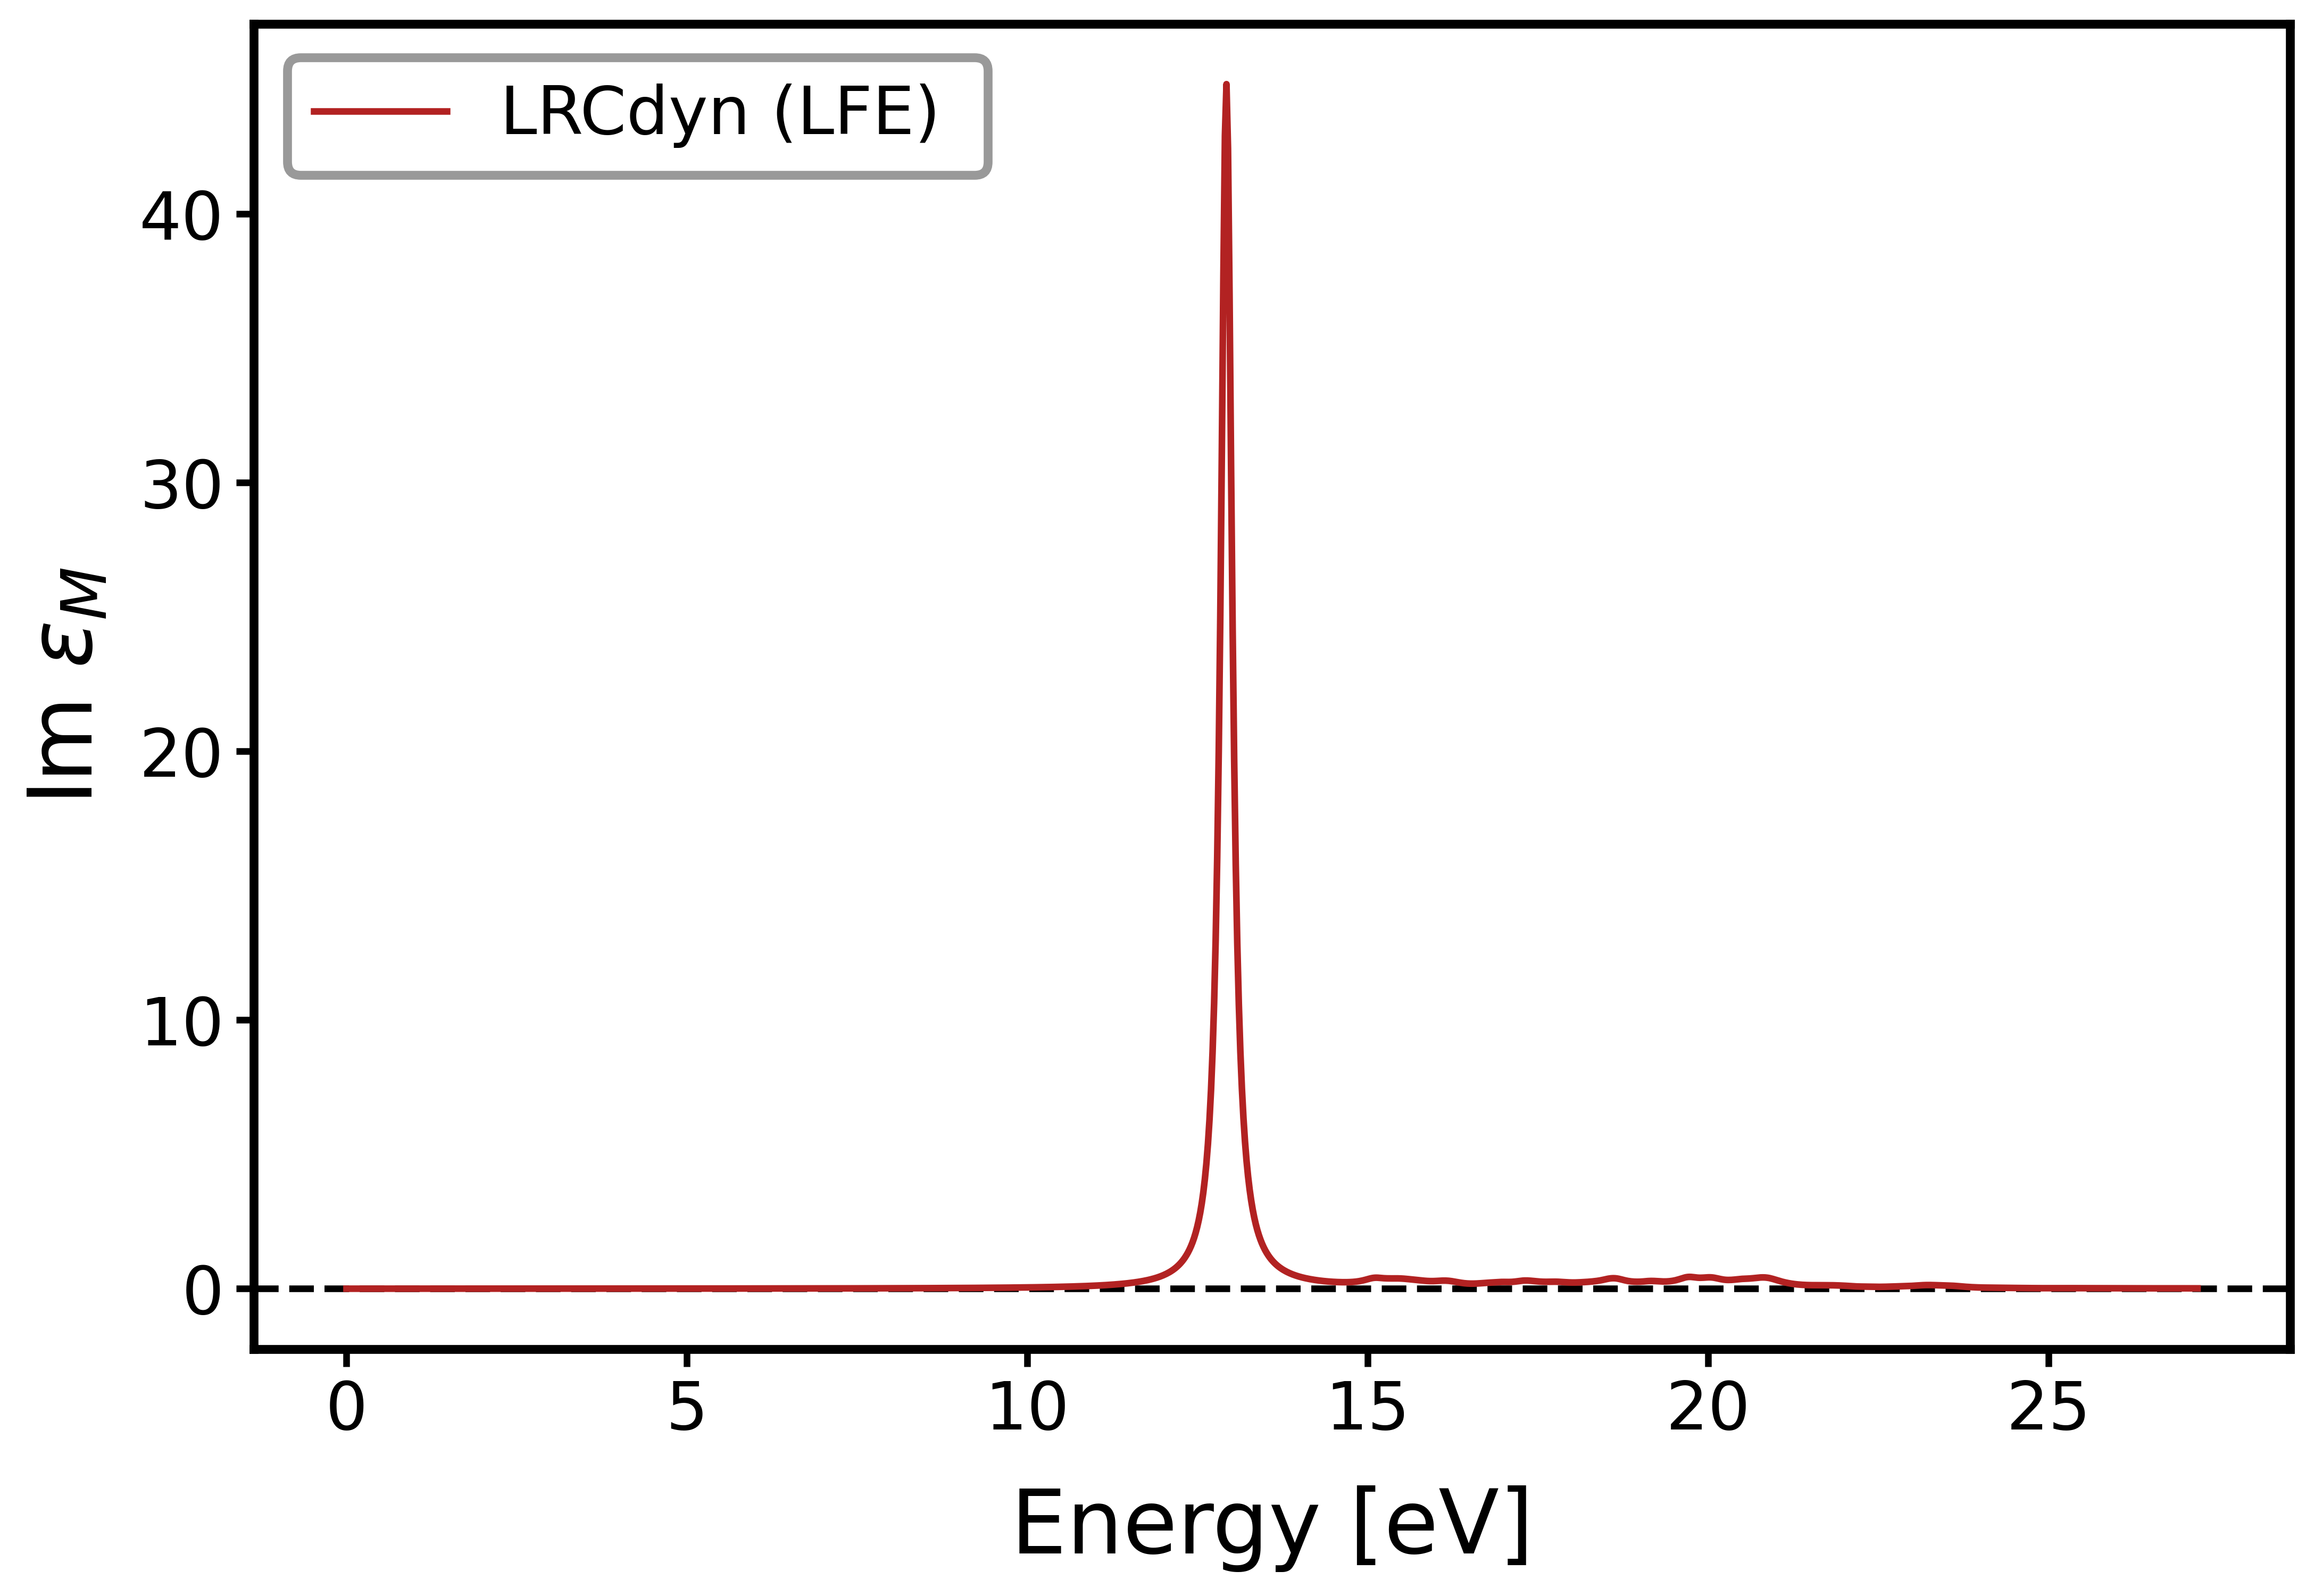" width="500" align="left"/>
</figure>

The first intense excitonic peak is again well reproduced by the **LRC** kernel.

Finally, we calculate the spectrum with the **RBO** kernel. In this case, the <code><span style="color:green">xs</span></code> block in the input file is the following:

```xml
...
   <xs 
      xstype="TDDFT" 
      ngridk="4 4 4" 
      vkloff="0.097 0.273 0.493"
      nempty="5"
      gqmax="3.0"
      broad="0.007"
      scissor="0.2095"
      tevout="true">
 
      <energywindow 
         intv="0.0 1.0" 
         points="1200"/>
 
      <tddft
         fxctype="RBO"
         />
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>
 
   </xs> 
...
```

In [18]:
parsed_input = ExcitingInputXML.from_xml('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [4, 4, 4],
      'vkloff': [0.097, 0.273, 0.493],
      'nempty': 5,
      'gqmax': 3.0,
      'broad': 0.007,
      'scissor': 0.2095,
      'tevout': True,
      'energywindow': {'intv': [0.0, 1.0], 'points': 1200},
      'tddft': {'fxctype': 'RBO'},
      'qpointset': [[0.0, 0.0, 0.0]]}

parsed_input.xs = ExcitingXSInput(**xs)

parsed_input.write('./run_LiF_TDDFT_kernels/LRC_RBO_kernel/input.xml')

As you can notice, now the <code><span style="color:green">tddft</span></code> element does not contain any empirical parameter, in accordance with the defining **Eq. (3)** above. The obtained spectrum shows a bound excitonic peak inside the band-gap, whose binding energy is in good agreement with experiment.

In [19]:
%%bash
cd run_LiF_TDDFT_kernels
python3 -m excitingscripts.execute.single -r LRC_RBO_kernel
cd ..

In order to compare the **RBO** result with the **LRC** static result and the **BSE**-derived **xc** kernel, we can generate a plot containing all the spectra together by executing:

In [21]:
%%bash
cd run_LiF_TDDFT_kernels/LRC_RBO_kernel
python3 -m excitingscripts.plot.spectra -f EPSILON_FXCLRCstatic_OC11_QMT001.OUT EPSILON_FXCRBO_OC11_QMT001.OUT ../BSE_kernel/EPSILON_NAR_FXCMB1_OC11_QMT001.OUT -pn 'XC_Kernel_Comparison'
cd ../..

The generated **XC_Kernel_Comparison.png** file looks like:

<figure>
<img src=" 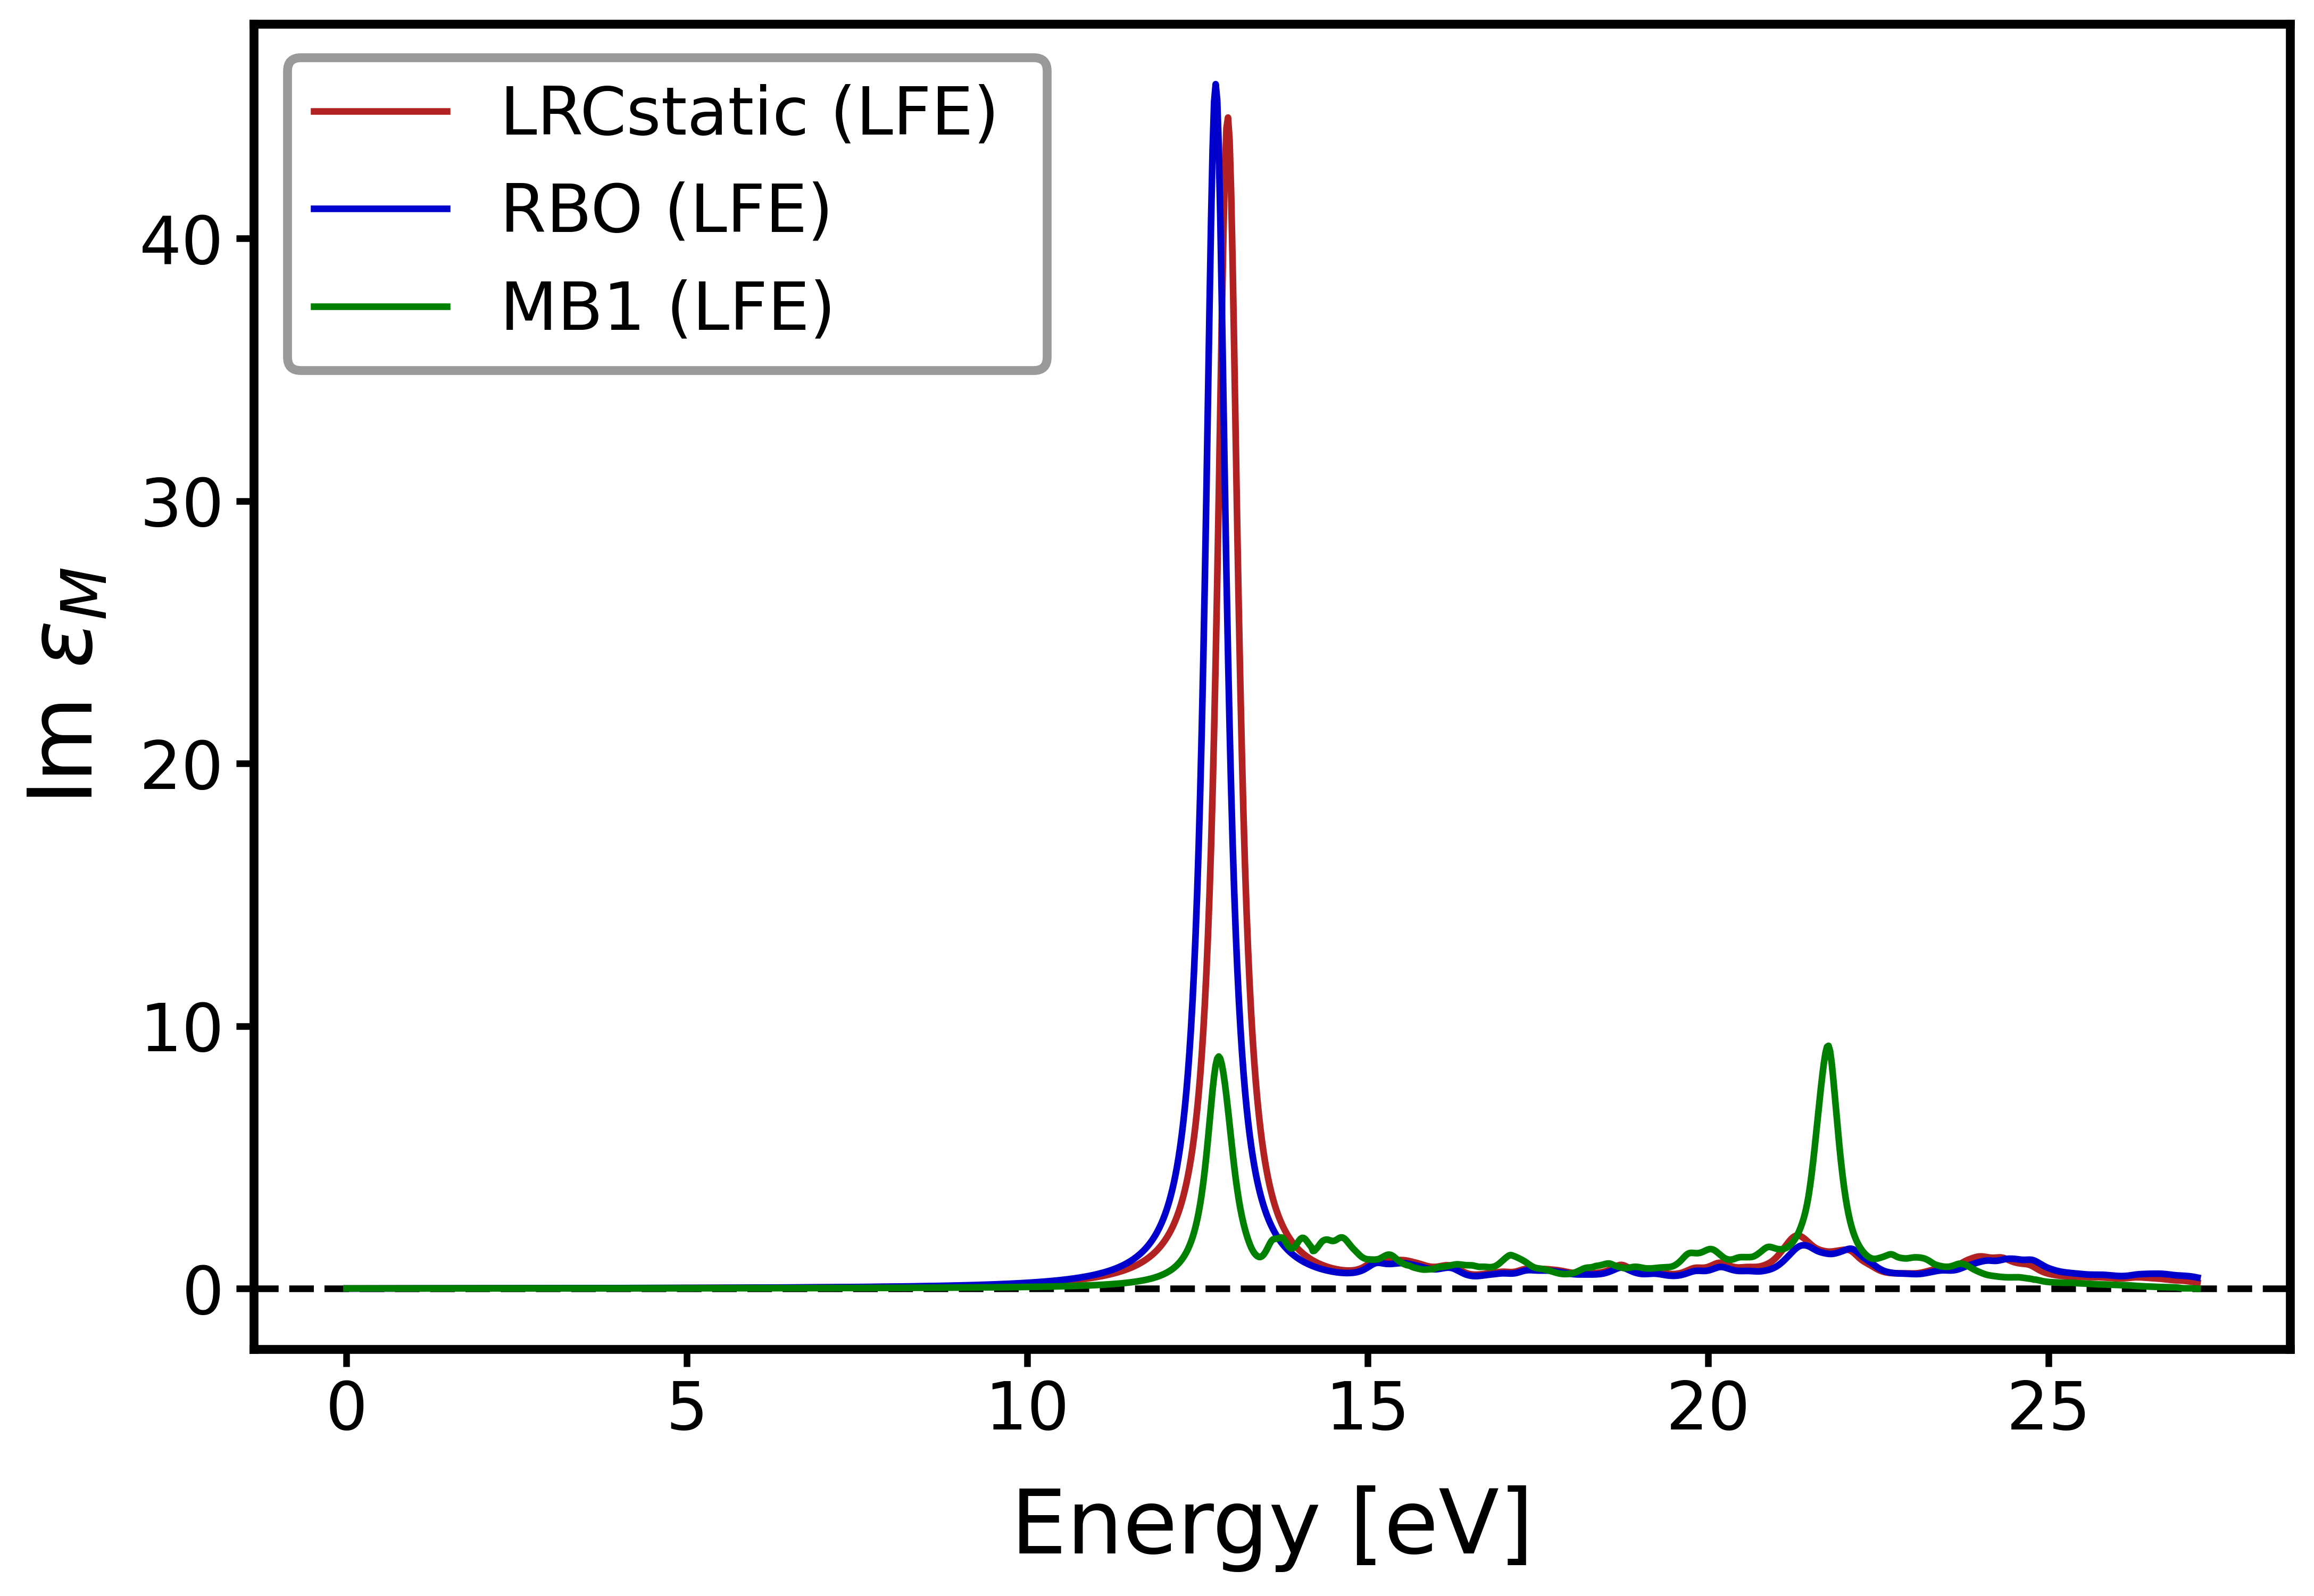" width="500" align="left"/>
</figure>

<a id='5'></a>
**<span style="color:green">Exercises</span>**
- If you have already done the tutorial **Excited states from TDDFT**, calculate the optical absorption spectrum for LiF using **RPA** and **ALDA** kernels. What happens to the excitonic peak?
- Decrease the parameter <code><span style="color:mediumblue">alphalrc</span></code> in the calculation with the static **LRC** kernel and check what happens to the excitonic peak. Compare your results with the onset of the spectrum obtained from the **RPA** calculation.
- Tune the parameters <code><span style="color:mediumblue">alphalrcdyn</span></code> and <code><span style="color:mediumblue">betalrcdyn</span></code>, following the rule of a thumb suggested above. What happens to the spectrum?

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Bibliography</span>
1. G. Onida, L. Reining, and A. Rubio, Rev. Mod. Phys. **74**, 601 (2002) (**[link](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.74.601)**).
2. A. Marini, R. Del Sole, and A. Rubio, Phys. Rev. Lett. **91**, 256402 (2003). (**[link](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.91.256402)**)
3. S. Sagmeister and C. Ambrosch-Draxl, Phys. Chem. Chem. Phys. **11**, 4451 (2009). (**[link](https://pubs.rsc.org/en/content/articlelanding/2009/cp/b903676h)**)
4. L. Reining, V. Olevano, A. Rubio, and G. Onida Phys. Rev. Lett. **88**, 066404 (2002). (**[link](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.88.066404)**)
5. S. Botti, A. Fourreau, F. Nguyen, Y.-O. Renault, F. Sottile, and L. Reining, Phys. Rev. B **72**, 125203 (2005). (**[link](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.72.125203)**)
6. S. Sharma, J. K. Dewhurst, A. Sanna, and E. K. U. Gross, Phys. Rev. Lett. **107**, 186401 (2011). (**[link](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.186401)**)
7. S. Rigamonti, S. Botti, V. Veniard, C. Draxl, L. Reining, and F. Sottile, Phys. Rev. Lett. **114**, 146402 (2015). (**[link](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.146402)**)

<hr style="border:2px solid #DDD"> </hr>